<h align="center">

# Fraudulent Review Detection

---
</h>


## Data importing

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
import pandas as pd
df = pd.read_csv('fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


<p>The generated fake reviews dataset, containing 20k fake reviews and 20k real product reviews. OR = Original reviews (presumably human created and authentic); CG = Computer-generated fake reviews.

<b>Acknowlegement:
Foto von Brett Jordan auf Unsplash</b>
</p>

In [3]:
df.shape

(40432, 4)

In [4]:
df['label'].value_counts(normalize = True)

label
CG    0.5
OR    0.5
Name: proportion, dtype: float64

<p>So that the data is balanced when it comes to being a fake review or not.</p>

In [5]:
df['rating'].value_counts(normalize = True)

rating
5.0    0.607415
4.0    0.196997
3.0    0.093639
1.0    0.053299
2.0    0.048650
Name: proportion, dtype: float64

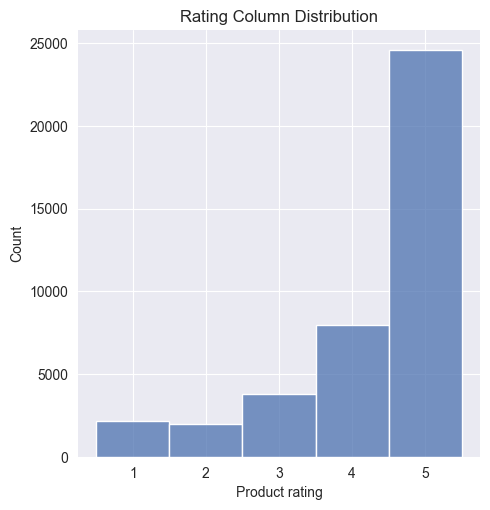

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes()
sns.set_style("darkgrid")
ax = sns.displot(df, x="rating", discrete=True, color ='b')
sns.despine(left=True, bottom=True)
plt.title("Rating Column Distribution")
plt.xlabel('Product rating')
plt.ylabel('Count')
plt.show()

## Text Preprocessing

In [46]:
import string
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /Users/sarayetel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sarayetel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sarayetel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
def preprocess_text(input_text):
    # Remove punctuation
    text_no_punctuation = "".join([char for char in input_text if char not in string.punctuation])
    # Split into words
    words = text_no_punctuation.split()
    # Remove stopwords
    meaningful_words = [word for word in words if word.lower() not in stopwords.words('english')]
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in meaningful_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    # Join words back into string
    result = " ".join(lemmatized_words)
    return result

In [48]:
df['text_'] = df['text_'].astype(str).apply(preprocess_text)
df['text_'].head()

0    love well made sturdi comfort love itveri pretti
1        love great upgrad origin ive mine coupl year
2              pillow save back love look feel pillow
3                 miss inform use great product price
4                 nice set good qualiti set two month
Name: text_, dtype: object

In [49]:
if df.isnull().values.any():
    num_rows_with_nan = df.isnull().any(axis=1).sum()
    print(f'There are {num_rows_with_nan} rows with NaN values in the DataFrame.')
    df = df.dropna()
    print('Rows with NaN values have been removed.')
else:
    print('There are no NaN values in the DataFrame.')

There are no NaN values in the DataFrame.


## Text Length Analysis and Visualization by Label Grouping

In [11]:
df['length'] = df['text_'].apply(len)

### histogram of text length

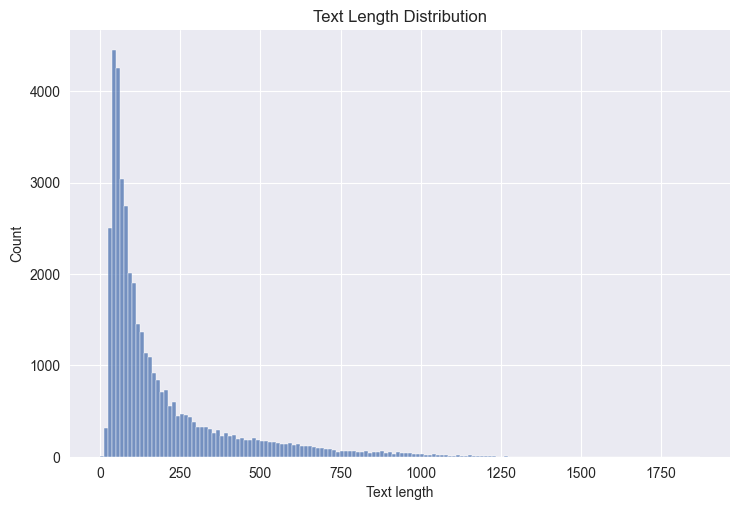

In [12]:
sns.set_color_codes()
sns.set_style("darkgrid")
ax = sns.displot(df, x="length", bins=150, color ='b', aspect=1.5)
sns.despine(left=True, bottom=True)
plt.title("Text Length Distribution")
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

### Display descriptive statistics

In [13]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20216.0  4.259893  1.141065  1.0  4.0  5.0  5.0  5.0  20216.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                
             mean         std  min   25%    50%    75%     max  
label                                                           
CG     154.869608  155.916219  0.0  51.0   89.0  192.0  1191.0  
OR     220.818461  235.364472  8.0  68.0  124.0  274.0  1872.0

### histograms of text length by label

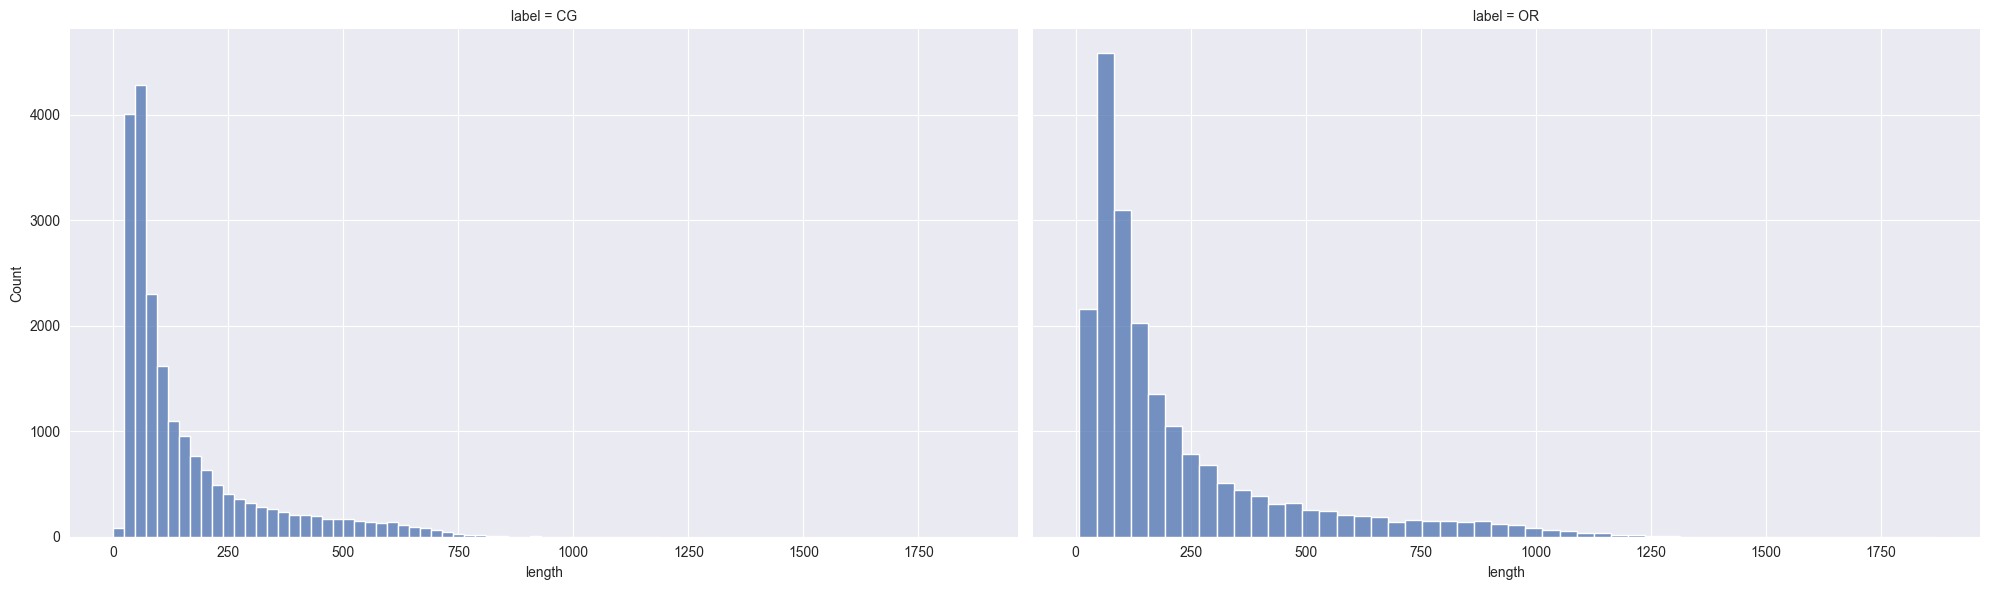

In [14]:
g = sns.FacetGrid(df, col="label", height=6, aspect=10/6)
g.map_dataframe(sns.histplot, x="length", bins=50, color ='b')
sns.despine(left=True, bottom=True)
plt.show()

## Text Processing and Feature Extraction

In [50]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [51]:
def process_text(review):
    no_punctuation = ''.join([char for char in review if char not in string.punctuation])
    return [word for word in no_punctuation.split() if word.lower() not in stopwords.words('english')]

### Bag of Words (BoW) transformer

In [52]:
# Creating a Bag of Words (BoW) transformer
bow_transformer = CountVectorizer(analyzer=process_text)
bow_reviews = bow_transformer.fit_transform(df['text_'])

In [53]:
# Checking the vocabulary size
vocab_size = len(bow_transformer.vocabulary_)
print("Total Vocabulary:", vocab_size)

Total Vocabulary: 37272


In [54]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 37272


In [55]:
# Transforming all reviews
bow_reviews = bow_transformer.transform(df['text_'])
print("Shape of transformed reviews:", bow_reviews.shape)
print("Non-zero occurrences:", bow_reviews.nnz)
print("Sparsity (the percentage of non-zero occurrences in the BoW matrix.): {:.2%}".format(bow_reviews.nnz / (bow_reviews.shape[0] * bow_reviews.shape[1])))

Shape of transformed reviews: (40432, 37272)
Non-zero occurrences: 1023501
Sparsity (the percentage of non-zero occurrences in the BoW matrix.): 0.07%


###  Term Frequency-Inverse Document Frequency (TF-IDF) transformer

In [56]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)

In [57]:
# Transforming all reviews
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape of transformed reviews:", tfidf_reviews.shape)
print("Number of dimensions:", tfidf_reviews.ndim)

Shape of transformed reviews: (40432, 37272)
Number of dimensions: 2


## Multi-Model Text Classification with Validation and Performance Metrics

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np

### Encoding the labels

In [59]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

### Splitting the data into train, validation, and test sets

In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text_'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

### Defining the pipeline for each model

In [26]:
pipelines = {
    'Naive Bayes': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', MultinomialNB())]),
    'SVM': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', SVC())]),
    'Logistic Regression': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', LogisticRegression())]),
    'Random Forest': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', RandomForestClassifier())]),
    'XGBoost': Pipeline([('bow', CountVectorizer(analyzer=process_text)), ('tfidf', TfidfTransformer()), ('classifier', XGBClassifier())])
}

### Training the models and printing the performance metrics

Performance of Naive Bayes:
F1 Score (Micro): 0.8544105523495465
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      3032
           1       0.88      0.82      0.85      3033

    accuracy                           0.85      6065
   macro avg       0.86      0.85      0.85      6065
weighted avg       0.86      0.85      0.85      6065

Confusion Matrix:
 [[2682  350]
 [ 533 2500]]
Model Prediction Accuracy: 85.44%


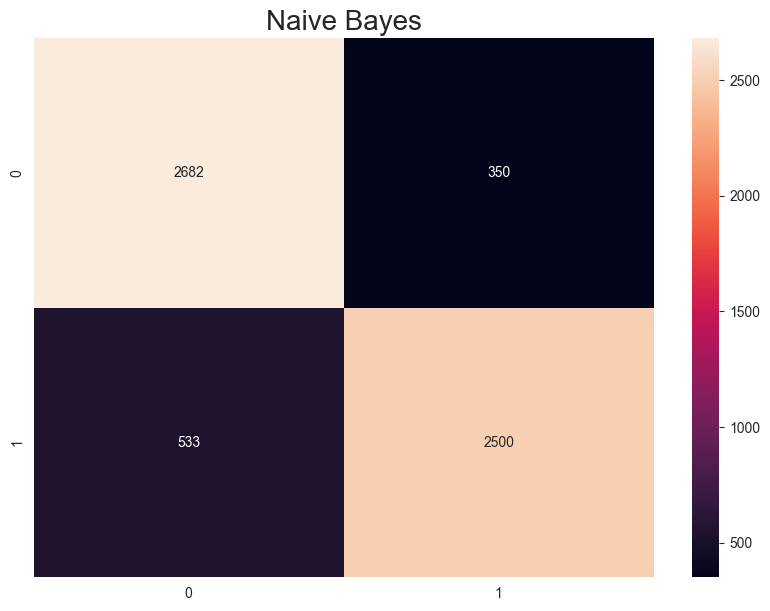

Performance of SVM:
F1 Score (Micro): 0.8827699917559769
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      3032
           1       0.87      0.90      0.88      3033

    accuracy                           0.88      6065
   macro avg       0.88      0.88      0.88      6065
weighted avg       0.88      0.88      0.88      6065

Confusion Matrix:
 [[2628  404]
 [ 307 2726]]
Model Prediction Accuracy: 88.28%


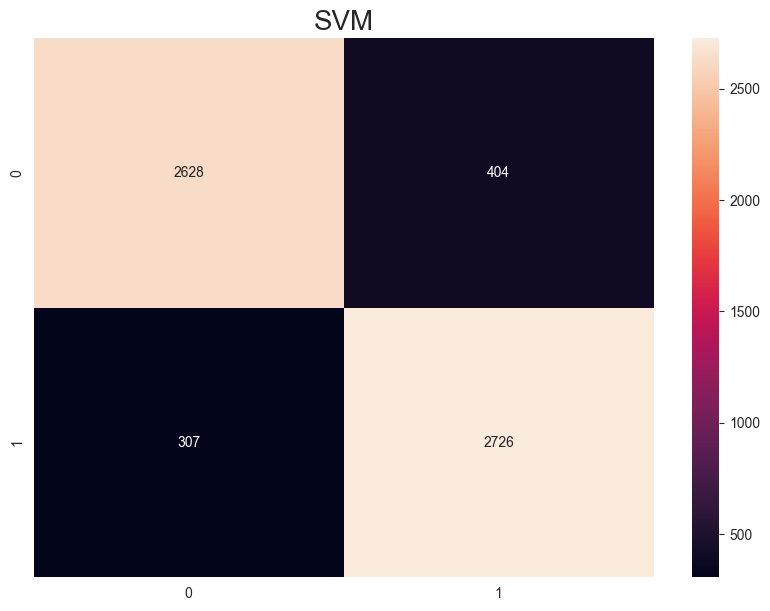

Performance of Logistic Regression:
F1 Score (Micro): 0.8700741962077494
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      3032
           1       0.86      0.88      0.87      3033

    accuracy                           0.87      6065
   macro avg       0.87      0.87      0.87      6065
weighted avg       0.87      0.87      0.87      6065

Confusion Matrix:
 [[2602  430]
 [ 358 2675]]
Model Prediction Accuracy: 87.01%


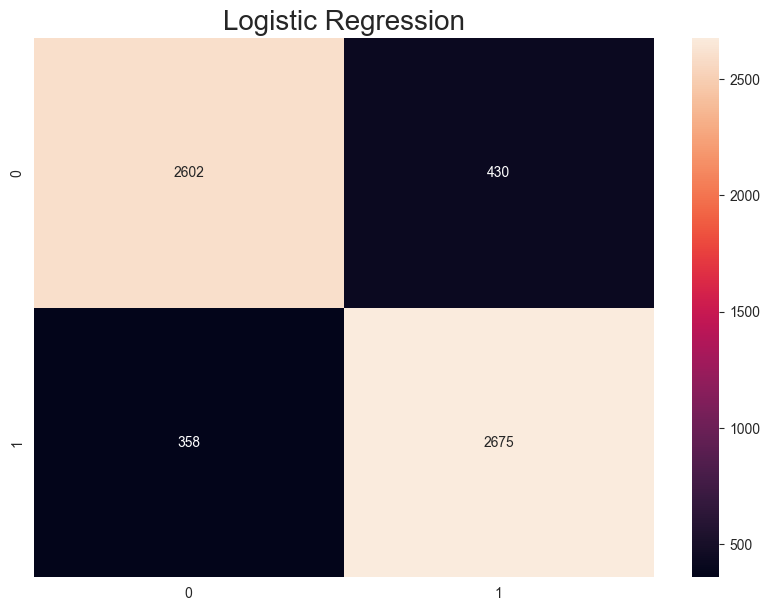

Performance of Random Forest:
F1 Score (Micro): 0.8492992580379225
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      3032
           1       0.89      0.80      0.84      3033

    accuracy                           0.85      6065
   macro avg       0.85      0.85      0.85      6065
weighted avg       0.85      0.85      0.85      6065

Confusion Matrix:
 [[2738  294]
 [ 620 2413]]
Model Prediction Accuracy: 84.93%


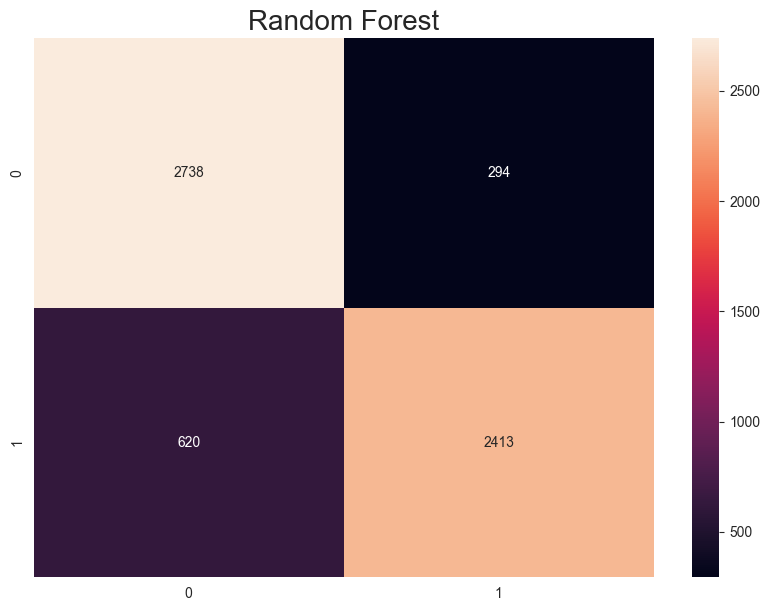

Performance of XGBoost:
F1 Score (Micro): 0.8329760923330586
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3032
           1       0.82      0.85      0.84      3033

    accuracy                           0.83      6065
   macro avg       0.83      0.83      0.83      6065
weighted avg       0.83      0.83      0.83      6065

Confusion Matrix:
 [[2462  570]
 [ 443 2590]]
Model Prediction Accuracy: 83.3%


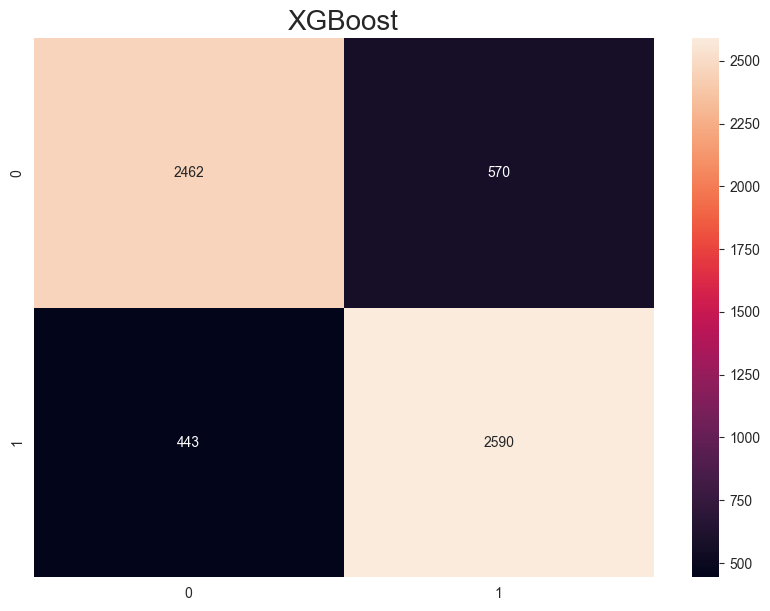

In [27]:
f1_scores = pd.DataFrame(columns=['Model', 'F1 Score (Micro)'])

for model, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_val)
    print(f'Performance of {model}:')
    f1_micro = f1_score(y_val, predictions, average='micro')
    print('F1 Score (Micro):', f1_micro)
    print('Classification Report:\n', classification_report(y_val, predictions))
    print('Confusion Matrix:\n', confusion_matrix(y_val, predictions))
    print('Model Prediction Accuracy:', str(np.round(accuracy_score(y_val, predictions)*100,2)) + '%')
    f1_scores = pd.concat([f1_scores, pd.DataFrame({'Model': [model], 'F1 Score (Micro)': [f1_micro]})], ignore_index=True)
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt='d')
    plt.title(model, fontsize=20)
    plt.show()

## The Best Model

In [28]:
f1_scores = f1_scores.sort_values(by='F1 Score (Micro)', ascending=False)
f1_scores.reset_index(drop=True, inplace=True)
f1_scores.index = range(1, len(f1_scores) + 1)

print(f1_scores)

                 Model  F1 Score (Micro)
1                  SVM          0.882770
2  Logistic Regression          0.870074
3          Naive Bayes          0.854411
4        Random Forest          0.849299
5              XGBoost          0.832976


### Testing the Best Model

In [29]:
svm_pipeline = pipelines['SVM'] 
svm_pipeline.fit(X_train, y_train)
svm_predictions = svm_pipeline.predict(X_test)
print('F1 Score (Micro) for SVM on test data:', f1_score(y_test, svm_predictions, average='micro'))

F1 Score (Micro) for SVM on test data: 0.8847485572959605


<h align="center">

# Predicting Fake Comments

---
</h>

### Data Import

In [ ]:
import pandas as pd
test_data_df = pd.read_csv('test_data.csv')
train_data_df = pd.read_csv('train_data.csv')
title_brand_df = pd.read_csv('title_brand.csv')

### Using the Best Model: SVM

In [61]:
pipeline_svm = Pipeline([('bow', CountVectorizer(analyzer=process_text)), 
                         ('tfidf', TfidfTransformer()), 
                         ('classifier', SVC())])

In [62]:
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x2c0446cb0>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [64]:
svm_predictions = pipeline_svm.predict(X_test)
print('F1 Score (Micro) for SVM on test data:', f1_score(y_test, svm_predictions, average='micro'))

F1 Score (Micro) for SVM on test data: 0.8847485572959605


### Text Preprocessing

In [69]:
import numpy as np 

np.random.seed(0)
train_data_df = train_data_df.sample(n=20000)

In [70]:
train_data_df['reviewText'] = train_data_df['reviewText'].astype(str).apply(preprocess_text)
train_data_df['summary'] = train_data_df['summary'].astype(str).apply(preprocess_text)

In [71]:
bow_transformer = CountVectorizer(analyzer=process_text)
bow_reviews = bow_transformer.fit_transform(train_data_df['reviewText'] + ' ' + train_data_df['summary'])

In [72]:
vocab_size = len(bow_transformer.vocabulary_)
print("Total Vocabulary:", vocab_size)

Total Vocabulary: 34019


In [73]:
print("Shape of transformed reviews:", bow_reviews.shape)

Shape of transformed reviews: (20000, 34019)


In [74]:
print("Non-zero occurrences:", bow_reviews.nnz)

Non-zero occurrences: 1016019


In [75]:
print("Non-zero occurrences:", bow_reviews.nnz)

Non-zero occurrences: 1016019


In [76]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_reviews = tfidf_transformer.transform(bow_reviews)

In [78]:
train_data_df['fake'] = pipeline_svm.predict(train_data_df['reviewText'] + ' ' + train_data_df['summary'])

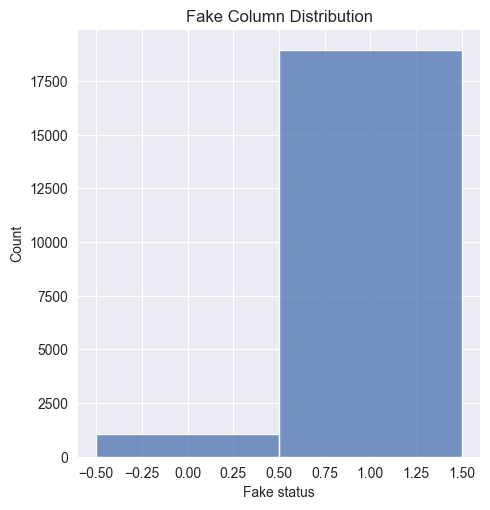

In [81]:
sns.set_color_codes()
sns.set_style("darkgrid")
ax = sns.displot(train_data_df, x="fake", discrete=True, color ='b')
sns.despine(left=True, bottom=True)
plt.title("Fake Column Distribution")
plt.xlabel('Fake status')
plt.ylabel('Count')
plt.show()

### top 10 'asin' with the most 0s in the 'fake' column

In [93]:
top_asin = train_data_df[train_data_df['fake'] == 0]['asin'].value_counts().nlargest(10)
total_asin_counts = train_data_df['asin'].value_counts()
top_asin_df = top_asin.reset_index().rename(columns={'index':'asin', 0:'top_asin_count'})
total_asin_counts_df = total_asin_counts.reset_index().rename(columns={'index':'asin', 0:'total_asin_count'})
merged_df = pd.merge(top_asin_df, total_asin_counts_df, on='asin')

print(merged_df)

         asin  count_x  count_y
0  B010OYASRG       10       55
1  B00F5NE2KG        5       22
2  B000VS4HDM        4       22
3  B01C6ESQM6        4       10
4  B0016P392O        4        4
5  B00B0RD2RA        4        7
6  B012BTCZ9G        3       12
7  B003LPTAYI        3        9
8  B00GZC35YK        3       11
9  B00C28L6EW        3       13


### the top 10 'brand' with the most 0s in the 'fake' column

In [95]:
merged_df = pd.merge(train_data_df, title_brand_df, on='asin')
top_brand = merged_df[merged_df['fake'] == 0]['brand'].value_counts().nlargest(10)
top_brand_df = top_brand.reset_index().rename(columns={'index':'brand', 0:'top_brand_count'})
total_brand_counts = merged_df['brand'].value_counts()
total_brand_counts_df = total_brand_counts.reset_index().rename(columns={'index':'brand', 0:'total_brand_count'})
final_df = pd.merge(top_brand_df, total_brand_counts_df, on='brand')

print(final_df)


          brand  count_x  count_y
0      Logitech       37      343
1          Sony       21      336
2       Samsung       18      460
3  AmazonBasics       15      292
4         Canon       15      117
5        Fintie       13      181
6         Nikon       13      106
7         Anker       13      196
8      StarTech       12      139
9       Sabrent       11      156


### the top 10 'reviewerID' with the most 0s in the 'fake' column

In [96]:
top_reviewer = train_data_df[train_data_df['fake'] == 0]['reviewerID'].value_counts().nlargest(10)
top_reviewer_df = top_reviewer.reset_index().rename(columns={'index':'reviewerID', 0:'top_reviewer_count'})
total_reviewer_counts = train_data_df['reviewerID'].value_counts()
total_reviewer_counts_df = total_reviewer_counts.reset_index().rename(columns={'index':'reviewerID', 0:'total_reviewer_count'})
final_df = pd.merge(top_reviewer_df, total_reviewer_counts_df, on='reviewerID')

print(final_df)


       reviewerID  count_x  count_y
0  A35SASDRENOXEJ        5        5
1  A2SCFPGT6CUZF7        4        4
2   A165DP7TELJ6S        3        6
3  A242R9BDV5GLG7        3        4
4  A1Y5TEGKKBL5X3        3        4
5  A2D8L49KEYKAQS        3        6
6  A2Y7E5QMHIWLJS        3        3
7  A2UN11524L3XXF        3        3
8  A2EK8BX02UKGU1        2        2
9  A1PGTL4FRI15F8        2        3


<h align="center">

# Time Series Analysis of Reviews

---
</h>

In [ ]:
import pandas as pd
test_data_df = pd.read_csv('test_data.csv')
train_data_df = pd.read_csv('train_data.csv')
title_brand_df = pd.read_csv('title_brand.csv')

In [2]:
train_data_df.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [3]:
train_data_df.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime'],
      dtype='object')

### Convert the 'reviewTime' column to datetime

In [4]:
train_data_df['reviewTime'] = pd.to_datetime(train_data_df['reviewTime'])

### Sort the DataFrame based on 'reviewTime'

In [5]:
train_data_df = train_data_df.sort_values(by='reviewTime')

### Create a new column 'polarity' using TextBlob to calculate polarity of 'reviewText'

In [7]:
from textblob import TextBlob

train_data_df['polarity'] = train_data_df['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
average_monthly_sentiment = train_data_df.resample('M', on='reviewTime')['polarity'].mean()

### Plot the average sentiment scores

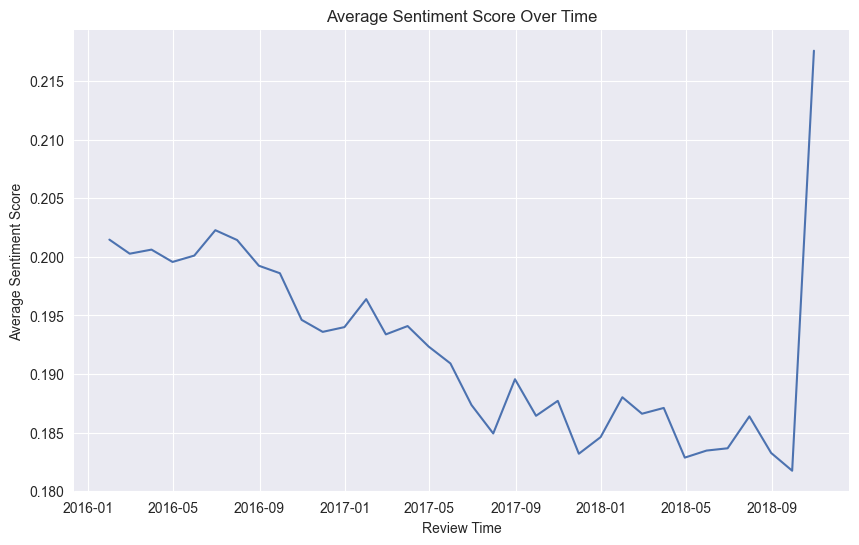

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_color_codes()
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
sns.lineplot(data=average_monthly_sentiment, color ='b')
sns.despine(left=True, bottom=True)
plt.title("Average Sentiment Score Over Time")
plt.xlabel('Review Time')
plt.ylabel('Average Sentiment Score')
plt.show()

### Calculate the average of ‘overall’ column for each month

In [13]:
average_monthly_overall = train_data_df.resample('M', on='reviewTime')['overall'].mean()

### Plot the average ‘overall’ scores:

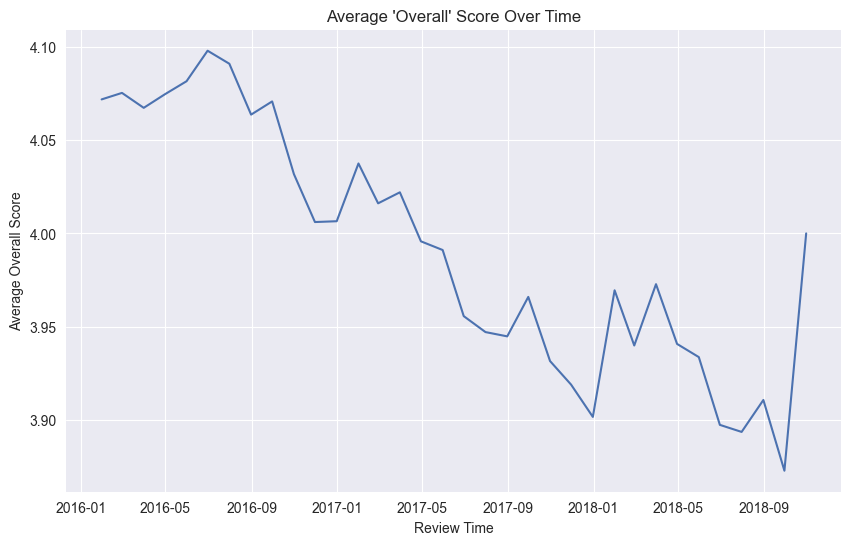

In [14]:
plt.figure(figsize=(10,6))
sns.lineplot(data=average_monthly_overall, color ='b')
sns.despine(left=True, bottom=True)
plt.title("Average 'Overall' Score Over Time")
plt.xlabel('Review Time')
plt.ylabel('Average Overall Score')
plt.show()

## Analyzing the Significat Change

### Filtering reviews that were made around the time of the change

In [15]:
start_date = '2018-08-01'
end_date = '2019-02-01'
mask = (train_data_df['reviewTime'] > start_date) & (train_data_df['reviewTime'] <= end_date)
filtered_reviews = train_data_df.loc[mask]

### Latent Dirichlet Allocation (LDA)

<p>a type of topic model, to find common topics in the reviews</p>

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
review_text = vectorizer.fit_transform(filtered_reviews['reviewText'])

# Initialize LDA Model with 10 topics
lda = LatentDirichletAllocation(n_components=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
lda.fit(review_text)

# For each topic, we can explore the words occuring in that topic and its relative weight
for idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (idx))
    print([(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-10 - 1:-1]])


Topic 0:
[('drive', 647.7032346091858), ('usb', 538.9512000841889), ('card', 426.26177636214527), ('drives', 234.9449003876877), ('windows', 214.85758859299438), ('files', 189.62423851928972), ('sd', 178.7736481622044), ('data', 159.0505897183196), ('computer', 151.39392651250304), ('flash', 142.58493250061548)]
Topic 1:
[('camera', 696.6876172357398), ('app', 491.7759939797805), ('cameras', 458.06496997763094), ('video', 328.2607349610786), ('work', 301.82729319663304), ('software', 290.1489947872169), ('device', 270.4167291521822), ('set', 253.58585096228478), ('antenna', 247.80621634493664), ('hdmi', 237.04718838875598)]
Topic 2:
[('camera', 580.3057345813111), ('lens', 367.55539855383), ('tripod', 131.39806026659764), ('focus', 112.5622458962746), ('lenses', 111.61980161834639), ('filter', 107.58225047499315), ('sony', 102.02620559635393), ('canon', 100.79681329050693), ('light', 91.03486169032338), ('zoom', 75.51556009224564)]
Topic 3:
[('good', 2009.2155715571255), ('great', 1987

### top 10 products with the most 5-star ratings in the ‘overall’ column during this period

In [26]:
five_star_reviews = filtered_reviews[filtered_reviews['overall'] == 5]
product_counts = five_star_reviews['asin'].value_counts()
top_10_products = product_counts[:10]
top_10_products_df = top_10_products.to_frame().reset_index()
top_10_products_df.columns = ['asin', 'counts']
merged_df = pd.merge(top_10_products_df, title_brand_df, on='asin', how='left')
print(merged_df[['asin', 'brand', 'title', 'counts']])


         asin                 brand  \
0  B00TQ6ZZSG   The Best Industries   
1  B0192911RA               NETGEAR   
2  B01D6JEMXC               NETGEAR   
3  B010OYASRG  Cambridge Soundworks   
4  B017N39T58                FORITO   
5  B017YEA6QW          AmazonBasics   
6  B01F9RGWF0          AmazonBasics   
7  B01621M1S4               NETGEAR   
8  B01G8JO5F2                 Senso   
9  B01GDIU3T0               Phaiser   

                                               title  counts  
0  Fujifilm FinePix S9900W Wi-Fi Digital Camera w...      35  
1  Netgear (R7800-100NAS) Nighthawk X4S AC2600 4x...      20  
2  NETGEAR AC1900 Mesh WiFi Extender, Seamless Ro...      19  
3  OontZ Angle 3 Enhanced Stereo Edition IPX5 Spl...      19  
4  Privacy Anti-Spy Screen Protector Guard Filter...      19  
5  AmazonBasics Lightning to USB A Cable - MFi Ce...      16  
6  AmazonBasics Nylon Braided Lightning to USB A ...      16  
7  NETGEAR Cable Modem 24x8 DOCSIS 3.0 Max Speed ...      15  
8  

### Visualization

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


top_10_asins = merged_df['asin'].values
filtered_train_data = train_data_df[train_data_df['asin'].isin(top_10_asins)]
filtered_train_data['reviewTime'] = pd.to_datetime(filtered_train_data['reviewTime'])
filtered_train_data.set_index('reviewTime', inplace=True)
average_ratings = filtered_train_data.groupby('asin').resample('M')['overall'].mean()
average_ratings_df = average_ratings.reset_index()
final_df = pd.merge(merged_df, average_ratings_df, on='asin', how='left')

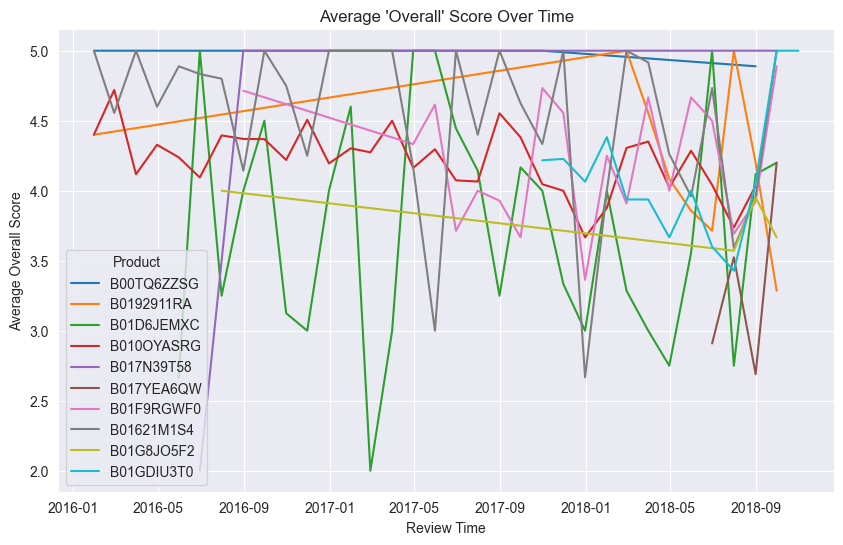

In [42]:
plt.figure(figsize=(10,6))
for product in final_df['asin'].unique():
    product_data = final_df[final_df['asin'] == product]
    sns.lineplot(data=product_data, x='reviewTime', y='overall_y', label=product)

sns.despine(left=True, bottom=True)
plt.title("Average 'Overall' Score Over Time")
plt.xlabel('Review Time')
plt.ylabel('Average Overall Score')
plt.legend(title='Product')
plt.show()

### top 10 products with the highest sentiment scores during this period

In [28]:
filtered_reviews.reset_index(drop=True, inplace=True)
product_sentiment = filtered_reviews.groupby('asin').resample('M', on='reviewTime')['polarity'].mean()
product_sentiment = product_sentiment.reset_index()
average_monthly_sentiment = product_sentiment.groupby('asin')['polarity'].mean()
top_10_products = average_monthly_sentiment.nlargest(10)
merged_df_score = pd.merge(top_10_products, title_brand_df, on='asin', how='left')
merged_df_score.columns = ['asin', 'mean_average_score', 'brand', 'title']  # rename the columns
print(merged_df_score)

         asin  mean_average_score  \
0  B0156YBCKG               1.000   
1  B01AHGIDE6               1.000   
2  B01ATFHU7Q               1.000   
3  B01DA3GD6I               1.000   
4  B01FVEBK2G               1.000   
5  B01H3Y3IL8               1.000   
6  B00KZGB01W               0.970   
7  B016TSL8HA               0.950   
8  B016K2W7E8               0.900   
9  B00MU2WXCY               0.825   

                                               brand                 title  
0  Nzxt GRID+V2, 12V Digital Fan Controller with ...                  Nzxt  
1  nbryte Tablift Tablet Stand for The Bed, Sofa,...                nbryte  
2  PAPAGO Car Dash Camera GoSafe 388 Full HD Dash...                PAPAGO  
3  EWETON 1/3&quot; 960H 1000TVL CCTV Home Survei...                EWETON  
4  LTGEM EVA Hard Case for JBL Charge 3 Waterproo...                 LTGEM  
5  AV.io 4K - Grab and Go USB Video Capture for H...  Epiphan Systems Inc.  
6  CHUYI 2.4GHz Wireless Sport Car Shaped Mouse 1... 

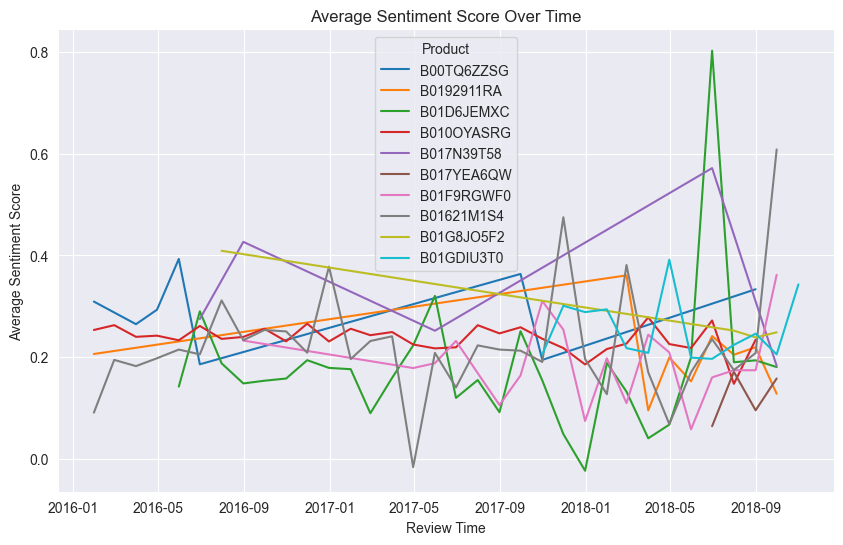

In [43]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract the 'asin' of the top 10 products from the merged_df
top_10_asins = merged_df['asin'].values

# Filter the train_data_df for these top 10 products
filtered_train_data = train_data_df[train_data_df['asin'].isin(top_10_asins)]

# Convert the 'reviewTime' column to datetime format
filtered_train_data['reviewTime'] = pd.to_datetime(filtered_train_data['reviewTime'])

# Set 'reviewTime' as the index of the DataFrame
filtered_train_data.set_index('reviewTime', inplace=True)

# Calculate the sentiment polarity for each review
filtered_train_data['polarity'] = filtered_train_data['reviewText'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Resample the data by month and calculate the mean of 'polarity'
average_ratings = filtered_train_data.groupby('asin').resample('M')['polarity'].mean()

# Reset the index
average_ratings_df = average_ratings.reset_index()

# Merge the average ratings with the merged_df
final_df = pd.merge(merged_df, average_ratings_df, on='asin', how='left')

# Plotting
plt.figure(figsize=(10,6))

# Plot a line for each product
for product in final_df['asin'].unique():
    product_data = final_df[final_df['asin'] == product]
    sns.lineplot(data=product_data, x='reviewTime', y='polarity', label=product)

sns.despine(left=True, bottom=True)
plt.title("Average Sentiment Score Over Time")
plt.xlabel('Review Time')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Product')
plt.show()
